### Imports


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


### Load Data

In [2]:
data = pd.read_csv("data/mushrooms.csv")


### Data Visualization

In [46]:
data.head(10)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


Display the distribution of edible and poisonous mushrooms.

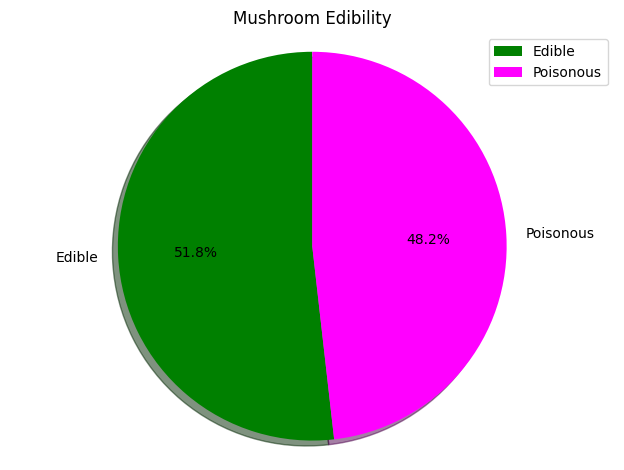

In [26]:
labels = "Edible", "Poisonous"
sizes = [
    data.describe()["class"]["freq"],
    data.describe()["class"]["count"] - data.describe()["class"]["freq"],
]

fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
    colors=["green", "magenta"],
)

ax.set_title("Mushroom Edibility")
ax.legend(labels, loc="upper right")
ax.axis("equal")
plt.tight_layout()

plt.show()


Mushroom edibility by cap shape

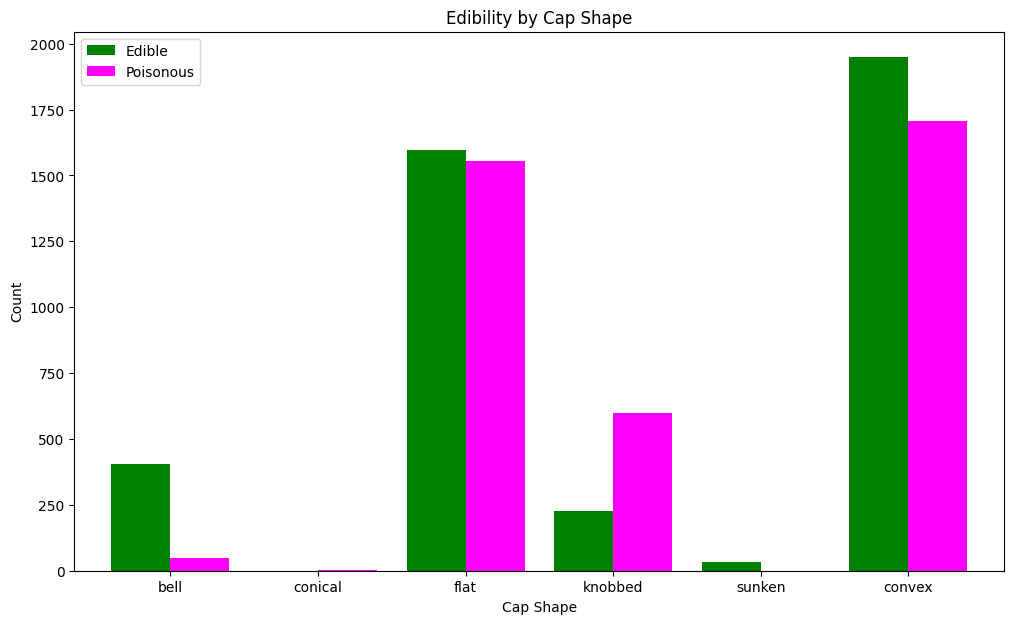

In [55]:
cap_shapes = data.groupby(["cap-shape", "class"]).size().unstack()
cap_shapes.fillna(0)
cap_shapes_mapping = {
    "b": "bell",
    "c": "conical",
    "x": "convex",
    "f": "flat",
    "k": "knobbed",
    "s": "sunken",
}

cap_shapes = cap_shapes.rename(index=cap_shapes_mapping)

ax = cap_shapes.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Edibility by Cap Shape")
ax.set_ylabel("Count")
ax.set_xlabel("Cap Shape")
labels = ["Edible", "Poisonous"]

plt.legend(labels, loc="upper left")
plt.show()


Mushroom edibility by cap surface

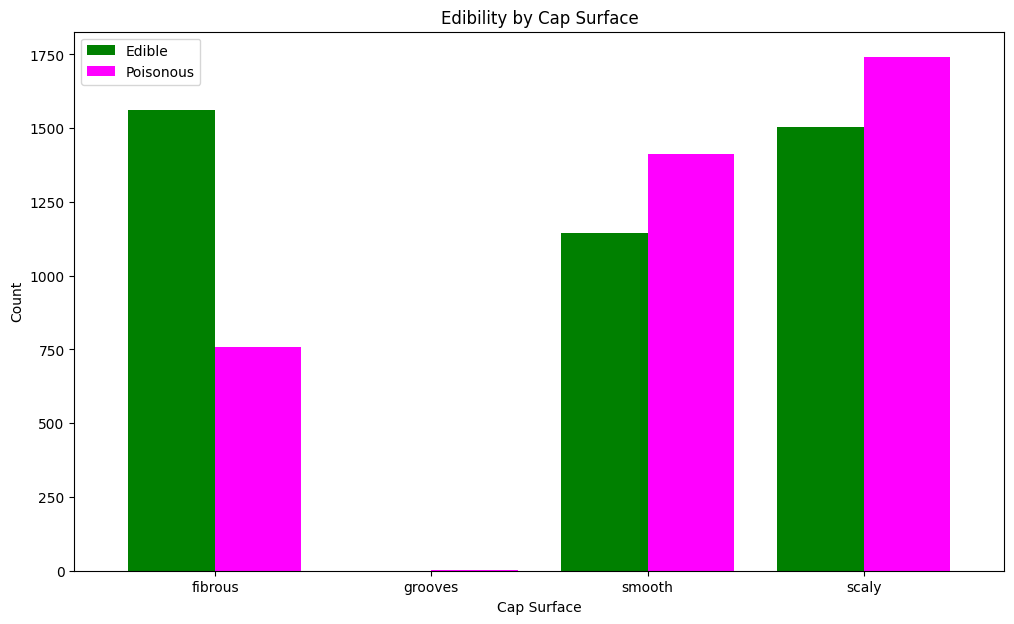

In [54]:
cap_surfaces = data.groupby(["cap-surface", "class"]).size().unstack()
cap_surfaces.fillna(0)

cap_surfaces_mapping = {
    "f": "fibrous",
    "g": "grooves",
    "s": "smooth",
    "y": "scaly",
}

cap_surfaces = cap_surfaces.rename(index=cap_surfaces_mapping)

ax = cap_surfaces.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Edibility by Cap Surface")
ax.set_ylabel("Count")
ax.set_xlabel("Cap Surface")
labels = ["Edible", "Poisonous"]

plt.legend(labels, loc="upper left")
plt.show()


### Train

Split the data into train and test 

In [49]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop("class", axis=1), data["class"], test_size=0.2
)
